<a href="https://colab.research.google.com/github/SalimHFX/FaceRecognition/blob/dev/%5BOT2%5DML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OT2 - Machine Learning project : L’apprentissage profond pour l’indexation d’une grande base d’images

Group 1 : 
- Salim HAFID
- Amine GADACHA
- Florencia CUZMAR

But : 90-95% d'accuracy sur le train set
      au moins 85% sur le test set

Première étape : Détecteur de visages sur des images 36x36
Deuxième étape : Le faire fonctionner sur des images de taille réelle

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

Get acces to the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Unzip the files

In [ ]:
!unzip -uq "/content/drive/My Drive/5IF/OT2/ML_PROJECT/start_deep.zip" -d "/content/drive/My Drive/5IF/OT2/ML_PROJECT/DATA"

error:  cannot create /content/drive/My Drive/5IF/OT2/ML_PROJECT/DATA/start_deep/train_images/1/Image006934.pgm
        Input/output error
replace /content/drive/My Drive/5IF/OT2/ML_PROJECT/DATA/start_deep/train_images/1/Image003712.pgm? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Load the Dataset**


In [ ]:
# In the folder "test_images" you can/should combine "google_faces" and "yale_faces" and rename it to "1"  (faces) and the other one "google_images02_36x36" to "0" (non-faces)
train_dir = '/content/drive/My Drive/5IF/OT2/ML_PROJECT/DATA/start_deep/train_images'
test_dir = '/content/drive/My Drive/5IF/OT2/ML_PROJECT/DATA/start_deep/test_images'

transform = transforms.Compose(
    [transforms.Grayscale(), 
     transforms.ToTensor(), 
     transforms.Normalize(mean=(0,),std=(1,))])

train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform)

valid_size = 0.2
# Un batch_size élevé permet de paralléliser si accès à un GPU et d'avoir une MAJ
# plus rapide des poids du net. En général la convergence est plus rapide avec
# des batchs petits mais l'exécution est plus lente (epochs plus longues)
# Valeurs = puissances de 2 en général, pour faciliter le travail GPU
batch_size = 32

num_train = len(train_data)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

train_sampler = SubsetRandomSampler(train_new_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Input images are 36x36 pixels
# Train dataset : 91 720 imgs (64 770 faces / 26 950 nofaces)
# Test dataset : 7628 imgs (6831 faces / 797 nofaces)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)
classes = ('noface','face')

Show some of the data images :

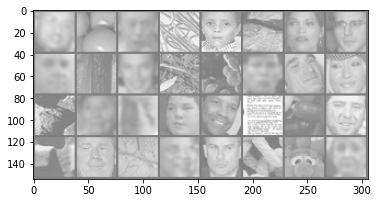

 face noface  face noface  face noface  face  face  face noface  face noface noface  face  face  face noface  face  face  face


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(20)))

**Define a Convolutional Neural Network**

Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).






In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Conseils d'ordre général sur les CNN
# - Les couches de Conv permettent de trouver les features locales. Les couches FC permettent de classifier les features
# - En général 1 à 3 couches FC. Ça n'ajoute rien de rajouter de la profondeur (i.e nb de couches) dans les couches FC. Rajouter plutôôt
#   de la largeur (nb neurones).
# - Beware : Trop de largeurs (neurones) -> Overfitting

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First convolutional layer : 1 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        # Pool Layer, 2x2 window
        self.pool = nn.MaxPool2d(2, 2)
        # Second convolutional layer : 6 input image channels, 16 output channels, 5x5 square convolution kernel
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 3 fully-connected layers - affine operation : y = Wx + b
        # value of linear params ??
        # 16 is defined by the nb of out_channels (i.e nb of filter kernels in the previous conv layer)
        # 5*5 is the spatial size defined by the conv and pooling operations performed on the input data
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        # Output of the last fc layer should be equal to the nb of classes
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        # Max-pooling with the pool layer
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = x.view(-1, 16 * 5 * 5) # ?
        # créer un vect 1D à partir d'une matrice 2D en concaténant les lignes
        x = x.view(-1,self.num_flat_features(x))
        # Two ReLu layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Final fc layer
        x = self.fc3(x)
        return x

    #nb total d'éléments
    def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
        num_features*= s
      return num_features


net = Net()

**Define a Loss function and Optimizer**

Methods used : Classification Cross-Entropy loss and SGD with momentum.

In [ ]:
import torch.optim as optim

# Try other loss functions, e.g MSE ?
# CrossEntropy -> 
criterion = nn.CrossEntropyLoss()
# Change optimizer's parameters ?
# lr = pas
# Trop faible -> met des heures/jours à converger
# Trop grand -> pbs numériques (NaN, infini)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Training on GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
net.to(device)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

**Train the network**

We simply loop over our data iterator, feed the data to the net and optimize

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # CPU version
        #inputs, labels = data
        # GPU version
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

KeyboardInterrupt: ignored

Save the model

In [ ]:
PATH = '/content/drive/My Drive/5IF/OT2/ML_PROJECT/DATA/model_v0.pth'
torch.save(net.state_dict(), PATH)

Test the network on the test Data

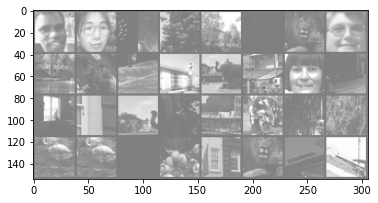

GroundTruth:   face  face noface noface noface noface noface  face noface noface


In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

Load back in our saved model (note: saving and re-loading the model wasn’t necessary here)

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

See how our net classifies the images 

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(10)))

Predicted:  noface noface noface noface noface noface noface noface noface noface


Let's look at how the net performs on the whole dataset

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (len(test_data),100 * correct / total))

Accuracy of the network on the 7628 test images: 89 %


Results : 

The high accuracy (89%) on the test dataset is due to a bias : the test dataset contains a lot more nofaces than faces (~90%) and our net usually predicts a noface, hence the false high accuracy

Now let's look at how the net performs on the train dataset (it's not a valuable performance metric, but if the net's accuracy is bad on its own training set, it will also be bad on the test set)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (len(train_data),100 * correct / total))

Accuracy of the network on the 91720 test images: 29 %


Results :
- Nb epochs : 2 - loss : 0.701 - Accuracy : 29%
- Nb epochs : 4 - loss : 0.701 - Accuracy : 29%